# Intro. to Snorkel: Extracting Spouse Relations from the News

## Part 3: Training the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass, and load the test set:

In [2]:
from snorkel.models import candidate_subclass
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

Load development set gold labels

In [3]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

Helper functions

In [4]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

## 1. Labeling Functions

Add all your labeling functions (and their dependencies) here. These will be used to train our generative model.

In [14]:
spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    return 1 if len(spouses.intersection(get_between_tokens(c))) > 0 else 0

def LF_husband_wife_left_window(c):
    if len(spouses.intersection(get_left_tokens(c[0], window=2))) > 0:
        return 1
    elif len(spouses.intersection(get_left_tokens(c[1], window=2))) > 0:
        return 1
    else:
        return 0
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return 1
    return 0

def LF_no_spouse_in_sentence(c):
    return -1 if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else 0

def LF_and_married(c):
    return 1 if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else 0
    
def LF_familial_relationship(c):
    return -1 if len(family.intersection(get_between_tokens(c))) > 0 else 0

def LF_family_left_window(c):
    if len(family.intersection(get_left_tokens(c[0], window=2))) > 0:
        return -1
    elif len(family.intersection(get_left_tokens(c[1], window=2))) > 0:
        return -1
    else:
        return 0
import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return 1 if (p1, p2) in known_spouses or (p2, p1) in known_spouses else 0

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return 1 if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else 0
    
def LF_other_relationship(c):
    return -1 if len(other.intersection(get_between_tokens(c))) > 0 else 0

Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.

Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [15]:
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

In [16]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train.shape

Clearing existing...
Running UDF...
[========================================] 100%%

CPU times: user 26.9 s, sys: 223 ms, total: 27.1 s
Wall time: 27.2 s


(4781, 10)

## 2: Unifying supervision

### Majority Vote
The most simple way to unify the output of all your LFs is by computed the _unweighted majority vote_. 

In [17]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%%



In [18]:
from utils import *

majority_vote_score(L_dev, L_gold_dev)

pos/neg    7:221 3.1%/96.9%
precision  54.55
recall     85.71
f1         66.67


### Generative Model
In data programming, we use a more sophisitcated model to unify our labeling functions. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [19]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-4)

Inferred cardinality: 2


In [22]:
for lf,w in zip(LFs,gen_model.weights.lf_accuracy):
    print lf.__name__,"\t",w

LF_distant_supervision 	0.0742702298477
LF_distant_supervision_last_names 	0.0718680652486
LF_husband_wife 	0.087537855672
LF_husband_wife_left_window 	0.0861201154539
LF_same_last_name 	0.070786373001
LF_no_spouse_in_sentence 	0.884057313179
LF_and_married 	0.0722481829437
LF_familial_relationship 	0.116445799825
LF_family_left_window 	0.108211404438
LF_other_relationship 	0.0811581251735


In [23]:
train_marginals = gen_model.marginals(L_train)

In [24]:
print train_marginals[0:10]

[ 0.14577695  0.14577695  0.14577695  0.14577695  0.5         0.5
  0.14577695  0.14577695  0.58596655  0.14577695]


### Plotting Marginal Probabilities
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training marginals. Ideally, there should get a bimodal distribution with large seperation between each peaks.

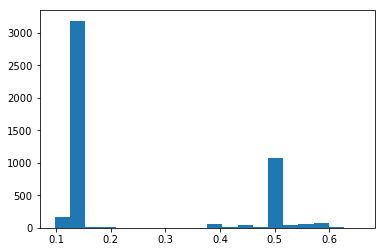

In [25]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [26]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.857
Neg. class accuracy: 0.977
Precision            0.545
Recall               0.857
F1                   0.667
----------------------------------------
TP: 6 | FP: 5 | TN: 216 | FN: 1



### Saving our training labels

Finally, we'll save the `training_marginals`, which are our **"noise-aware training labels"**, so that we can use them in the next tutorial to train our end extraction model:

In [27]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 4781 marginals
CPU times: user 2.53 s, sys: 14.6 ms, total: 2.54 s
Wall time: 2.55 s


## 4. Structure Learning

We want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. 

In [31]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.3)
print len(deps)

8


In [32]:
deps

{(0, 1, 0),
 (0, 6, 0),
 (0, 9, 0),
 (1, 4, 0),
 (1, 6, 0),
 (2, 3, 0),
 (6, 9, 0),
 (7, 8, 0)}

Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [33]:
gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-4
)

Inferred cardinality: 2


In [34]:
train_marginals = gen_model.marginals(L_train)

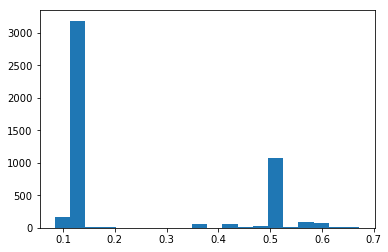

In [35]:
plt.hist(train_marginals, bins=20)
plt.show()

In [36]:
dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.857
Neg. class accuracy: 0.977
Precision            0.545
Recall               0.857
F1                   0.667
----------------------------------------
TP: 6 | FP: 5 | TN: 216 | FN: 1

